In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Rose', 'habituation1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3013.42 seconds 
duration: 0.84 hours 



## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Sync_USV_and_Ephys(Rose_habituation1).ipynb saved to /data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_Sync_USV_and_Ephys(Rose_habituation1).ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 22.2 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,284.9252,287.0948,None,2.1696
1,1473.0000,1473.2500,None,0.2500
2,1528.6508,1530.1308,None,1.4800
3,2292.9044,2294.2212,None,1.3168
4,2333.2292,2338.8908,None,5.6616
5,2572.7540,2584.0908,None,11.3368


<Axes: >

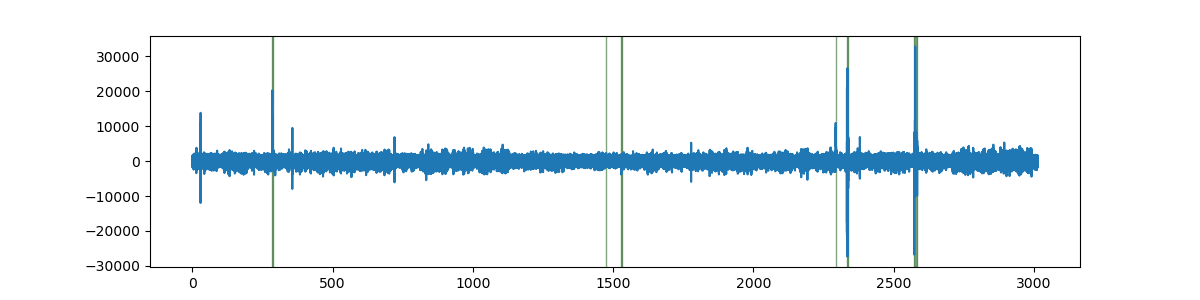

In [7]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.probegroup.npy saved


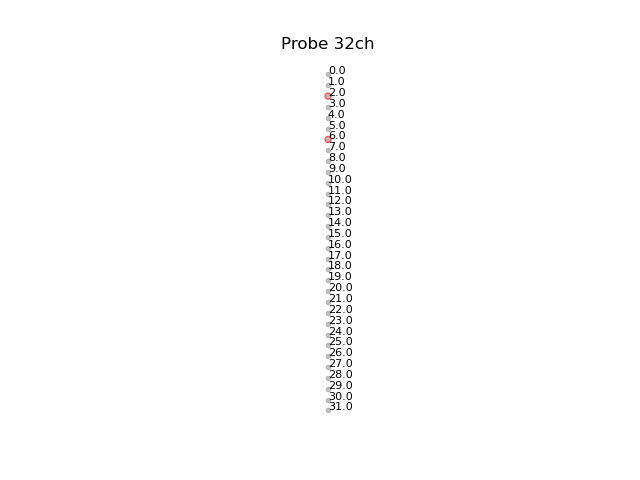

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [24]
232 epochs remaining with durations within (1,20)


In [10]:
from neuropy.analyses.oscillations import detect_gamma_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
gamma_channel = 24

## Detect SWR Epochs

In [11]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [24]
2869 epochs remaining with durations within (0.05,0.45)


In [12]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
freq_band = (0.5, 4)
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24 

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

192 delta waves detected


In [13]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [24]
194 epochs remaining with durations within (1,20)


In [14]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 21

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
913,2,4024567,2022-06-20 12:27:29.152233333,
1061,-2,4322215,2022-06-20 12:27:39.073833333,
1890,2,5996507,2022-06-20 12:28:34.883566667,
2039,-2,6294701,2022-06-20 12:28:44.823366667,
2853,2,7938454,2022-06-20 12:29:39.615133333,


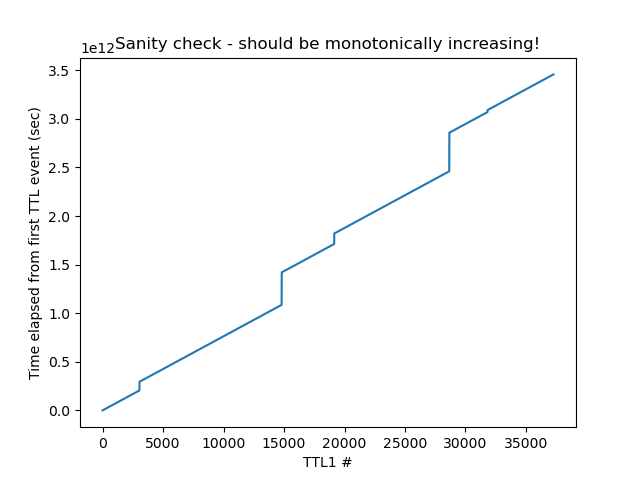

In [15]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [16]:
sess.basepath

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1')

In [17]:
import tracefc.io.traceio as traceio
csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", event_type="CS-", return_df=True)

print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts)
print(csn_stops)

15 CS- events detected
       Time (s)       Event                     Timestamp
5     61.595193   CS1_start 2022-06-20 12:27:29.587902386
7    127.326500   CS2_start 2022-06-20 12:28:35.319208939
9    192.057891   CS3_start 2022-06-20 12:29:40.050600130
11   265.734472   CS4_start 2022-06-20 12:30:53.727181275
13   327.360641   CS5_start 2022-06-20 12:31:55.353350003
15   391.077719   CS6_start 2022-06-20 12:32:59.070428450
17   454.795312   CS7_start 2022-06-20 12:34:02.788020928
19   516.467917   CS8_start 2022-06-20 12:35:04.460625965
21   597.436246   CS9_start 2022-06-20 12:36:25.428954918
23   659.122740  CS10_start 2022-06-20 12:37:27.115448792
25   724.853586  CS11_start 2022-06-20 12:38:32.846295435
27   790.599323  CS12_start 2022-06-20 12:39:38.592031796
29   864.464510  CS13_start 2022-06-20 12:40:52.457219441
31   939.313619  CS14_start 2022-06-20 12:42:07.306328375
33  1014.192848  CS15_start 2022-06-20 12:43:22.185557444
       Time (s)     Event                     Tim

In [18]:
import tracefc.io.traceio as traceio
csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", event_type="CS-", return_df=True)

csn_starts = csn_starts.drop(csn_starts.index[3])
csn_stops = csn_stops.drop(csn_stops.index[3])

# Reset index after dropping the rows, if you want a continuous index
csn_starts = csn_starts.reset_index(drop=True)
csn_stops = csn_stops.reset_index(drop=True)


print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts)
print(csn_stops)

14 CS- events detected
       Time (s)       Event                     Timestamp
0     61.595193   CS1_start 2022-06-20 12:27:29.587902386
1    127.326500   CS2_start 2022-06-20 12:28:35.319208939
2    192.057891   CS3_start 2022-06-20 12:29:40.050600130
3    327.360641   CS5_start 2022-06-20 12:31:55.353350003
4    391.077719   CS6_start 2022-06-20 12:32:59.070428450
5    454.795312   CS7_start 2022-06-20 12:34:02.788020928
6    516.467917   CS8_start 2022-06-20 12:35:04.460625965
7    597.436246   CS9_start 2022-06-20 12:36:25.428954918
8    659.122740  CS10_start 2022-06-20 12:37:27.115448792
9    724.853586  CS11_start 2022-06-20 12:38:32.846295435
10   790.599323  CS12_start 2022-06-20 12:39:38.592031796
11   864.464510  CS13_start 2022-06-20 12:40:52.457219441
12   939.313619  CS14_start 2022-06-20 12:42:07.306328375
13  1014.192848  CS15_start 2022-06-20 12:43:22.185557444
       Time (s)     Event                     Timestamp
0     71.517087   CS1_end 2022-06-20 12:27:39.50979

In [19]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-06-20 12:25:15.439191-04:00
start time = 2022-06-20 12:31:16.481813-04:00
start time = 2022-06-20 12:49:31.360788-04:00
start time = 2022-06-20 12:56:43.865791-04:00
start time = 2022-06-20 13:12:10.605629-04:00
start time = 2022-06-20 13:13:32.336581-04:00
start time = 2022-06-20 13:17:58.502688-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-06-20 12:25:15.439191-04:00,start,0,0.000000,0,0.0000
1,0,2022-06-20 12:30:00.614624333-04:00,stop,8555263,285.175433,356469,285.1752
2,1,2022-06-20 12:31:16.481813-04:00,start,8555264,285.175467,356470,285.1760
3,1,2022-06-20 12:46:28.857246333-04:00,stop,35926527,1197.550900,1496938,1197.5504
4,2,2022-06-20 12:49:31.360788-04:00,start,35926528,1197.550933,1496939,1197.5512
5,2,2022-06-20 12:55:02.710088-04:00,stop,45867007,1528.900233,1911125,1528.9000
6,3,2022-06-20 12:56:43.865791-04:00,start,45867008,1528.900267,1911126,1528.9008
7,3,2022-06-20 13:09:28.119624333-04:00,stop,68794623,2293.154100,2866442,2293.1536
8,4,2022-06-20 13:12:10.605629-04:00,start,68794624,2293.154133,2866443,2293.1544
9,4,2022-06-20 13:12:55.806662333-04:00,stop,70150655,2338.355167,2922943,2338.3544


In [20]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.3, unit="seconds")
csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.46913140485714283, std = 0.018185528404650503
start time lag: mean = -0.46950498700000004, std = 0.018182205555563855


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [21]:
csn_starts_combined

array([ 133.713042,  199.444375,  264.175942,  323.568387,  387.28562 ,
        451.003387,  512.676087,  593.644653,  655.331287,  721.062287,
        786.808187,  860.673553,  935.523053, 1010.402753])

In [22]:
csn_starts

,Time (s),Event,Timestamp
0,61.595193,CS1_start,2022-06-20 12:27:29.587902386
1,127.326500,CS2_start,2022-06-20 12:28:35.319208939
2,192.057891,CS3_start,2022-06-20 12:29:40.050600130
3,327.360641,CS5_start,2022-06-20 12:31:55.353350003
4,391.077719,CS6_start,2022-06-20 12:32:59.070428450
5,454.795312,CS7_start,2022-06-20 12:34:02.788020928
6,516.467917,CS8_start,2022-06-20 12:35:04.460625965
7,597.436246,CS9_start,2022-06-20 12:36:25.428954918
8,659.122740,CS10_start,2022-06-20 12:37:27.115448792
9,724.853586,CS11_start,2022-06-20 12:38:32.846295435


In [23]:
csn_stops

,Time (s),Event,Timestamp
0,71.517087,CS1_end,2022-06-20 12:27:39.509795505
1,137.266747,CS2_end,2022-06-20 12:28:45.259455759
2,201.996155,CS3_end,2022-06-20 12:29:49.988864024
3,337.294935,CS5_end,2022-06-20 12:32:05.287643511
4,401.014496,CS6_end,2022-06-20 12:33:09.007204611
5,464.713739,CS7_end,2022-06-20 12:34:12.706447680
6,526.403208,CS8_end,2022-06-20 12:35:14.395917256
7,607.372529,CS9_end,2022-06-20 12:36:35.365237791
8,669.042158,CS10_end,2022-06-20 12:37:37.034866888
9,734.791360,CS11_end,2022-06-20 12:38:42.784069140


In [24]:
csn_oe_start_df

,channel_states,timestamps,datetimes,event_name
913,2,4024567,2022-06-20 12:27:29.152233333-04:00,
1890,2,5996507,2022-06-20 12:28:34.883566667-04:00,
2853,2,7938454,2022-06-20 12:29:39.615133333-04:00,
492,2,1166226,2022-06-20 12:31:54.874200-04:00,
1440,2,3077743,2022-06-20 12:32:58.591433333-04:00,
2388,2,4989276,2022-06-20 12:34:02.309200-04:00,
3305,2,6839457,2022-06-20 12:35:03.981900-04:00,
4509,2,9268514,2022-06-20 12:36:24.950466667-04:00,
5426,2,11119113,2022-06-20 12:37:26.637100-04:00,
6404,2,13091043,2022-06-20 12:38:32.368100-04:00,


### How to write CS+ to neuroscope event file

In [25]:
csn_tone_recall_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ["CS-"]*len(csn_starts_combined)})
csn_tone_recall_epochs
sess.recinfo.write_epochs(csn_tone_recall_epochs, "CS-")

In [26]:
csn_tone_recall_epochs

14 epochs
Snippet: 
         start        stop label
0  133.713042  143.634642   CS-
1  199.444375  209.384175   CS-
2  264.175942  274.113809   CS-
3  323.568387  333.502287   CS-
4  387.285620  397.221920   CS-

In [27]:
# Detect CS+ in audio recording.
#from tracefc.io.traceio import grab_usv_folder
#csp_wav = grab_usv_folder(sess.basepath, 'csp')
#print(csp_wav)
## Get CS+ times and plot to check
#cs_wav_epochs, cs_wav_stop = detect_tone(csp_wav, freq_lims=(6900, 7100), thresh=0.05, tone_length=10, tone_label="CS+", 
#                                         plot_check=True, return_stop=True)
## Check that lags are consistent
#cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
#print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
#cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
#print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

In [28]:
csn_starts_combined

array([ 133.713042,  199.444375,  264.175942,  323.568387,  387.28562 ,
        451.003387,  512.676087,  593.644653,  655.331287,  721.062287,
        786.808187,  860.673553,  935.523053, 1010.402753])

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/1_tone_habituation/restbox/T0000001.wav
Mean start lag time of -12.993 sec with std = 31.171 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of -13.260 sec with std = 31.183 sec.


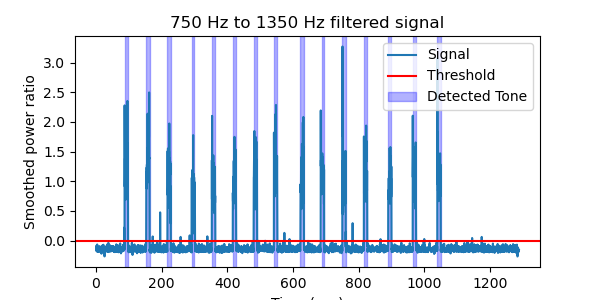

In [29]:
# Detect CS- in audio recording.
from tracefc.io.traceio import grab_usv_folder
csn_wav = grab_usv_folder(sess.basepath, 'csn')
print(csn_wav)
# Get CS- times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(750, 1350), thresh=0.0, 
                                           tone_length=6, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Manually exclude tone 3 because it is not in ephys recording file AND change tone 9 start!
csn_wav_starts = np.array([csn_wav_epochs.starts]) 
csn_wav_stops = np.array([csn_wav_epochs.stops]) 
csn_wav_starts = np.delete(csn_wav_starts, 3)
csn_wav_starts[8] = 684.425  # Manually set tone 9 (8) start time!
csn_wav_stops = np.delete(csn_wav_stops, 3)
csn_start_lags = csn_starts_combined - csn_wav_starts
csn_stop_lags = csn_stops_combined - csn_wav_stops

## Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

In [30]:
csn_wav_epochs

15 epochs
Snippet: 
         start        stop label
0   87.008824   97.184706   CS-
1  152.747647  162.919706   CS-
2  217.491471  227.675294   CS-
3  292.350588  299.330000   CS-
4  352.804118  363.011176   CS-

In [31]:
csn_start_lags

array([ 46.70421847,  46.69672794,  46.68447141, -29.23573065,
       -29.25290941, -29.26778947, -29.268913  , -29.280347  ,
       -29.093713  , -29.30183065, -29.31063653, -29.32497641,
       -29.31253524, -29.34459994])

In [32]:
csn_wav_starts[8]

684.425

In [33]:
csn_wav_stops

array([  97.18470588,  162.91970588,  227.67529412,  363.01117647,
        426.73558824,  490.44941176,  552.13647059,  633.11411765,
        694.79235294,  760.55970588,  826.32147059,  900.12970588,
        975.05058824, 1049.91117647])

Now try to sync to start tone 

In [34]:
#no_tone_wave = grab_usv_folder(sess.basepath, "sync")
#print(no_tone_wav)

# Get CS+ times and plot to check
#start_wav_epochs, start_wav_stop = detect_tone(no_tone_wav, freq_lims=(450, 550), thresh=3, tone_length=0.5, tone_label="start_tone", 
                               #plot_check=True, return_stop=True)

## Sync recorded USV times to ephys file

In [35]:
Path(csn_wav)

PosixPath('/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/1_tone_habituation/restbox/T0000001.wav')

In [36]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(Path(csn_wav).parent.glob(f"**/{Path(csn_wav).name[:-4]}*_cell.mat"))[0]
ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df.sample(5)

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
24,310.636794,56.960973,0.040069,13.677602,1,1
7,46.027513,46.551471,0.047393,7.625566,1,1
13,70.115037,40.257353,0.049117,10.530543,1,1
6,44.802671,48.730204,0.147350,26.144796,1,1
2,11.473934,44.493778,0.069798,10.288462,1,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

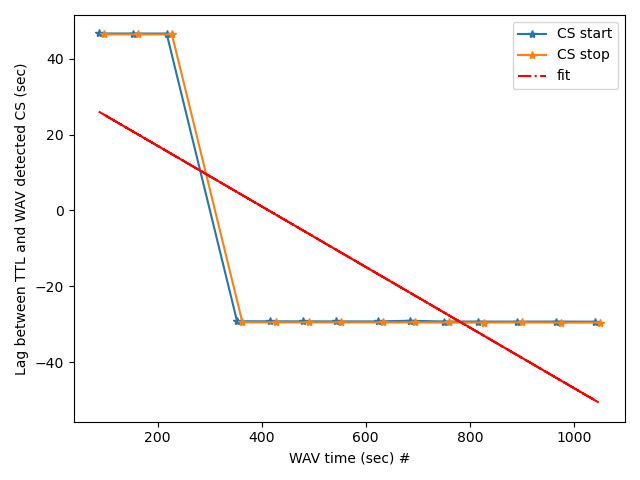

In [37]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
csn_times_wav = np.stack((csn_wav_starts, csn_wav_stops), axis=1)
csn_lags_comb = np.stack((csn_start_lags, csn_stop_lags), axis=1)
hl = ax.plot(csn_times_wav, csn_lags_comb, '*-')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = csn_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(csn_lags_comb.reshape(-1)), csn_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(csn_times_wav.T.reshape(-1), p[0] + p[1]*csn_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [38]:
def get_wav_to_dat_equation(cs_wav_epochs, cs_start_lags, cs_stop_lags, sync_df):
    """Get equation to convert cs times to dat file times"""
    pass
    # 1) Get rough alignment by identifying FIRST tone and getting datetime for each tone

    # 2) Identify any disconnect times and split into epochs of continuous recording

    # 3) Call function recursively for each epoch

    # 4) Fit a line to the lag data - in the case that there is only one point, return a Nan

    # 5) Go back and re-fit any NaN epochs using the mean slope from another epoch

    # 6) Return a dataframe with epoch start stop (from sync file) + appropriate slope and intercept to use!
    

In [39]:
csn_wav_stops

array([  97.18470588,  162.91970588,  227.67529412,  363.01117647,
        426.73558824,  490.44941176,  552.13647059,  633.11411765,
        694.79235294,  760.55970588,  826.32147059,  900.12970588,
        975.05058824, 1049.91117647])

In [40]:
wav_rough_start = csn_oe_start_df.iloc[0].datetimes - pd.Timedelta(csn_times_wav[0][0], 'seconds')
print(wav_rough_start)
wav_rough_stop = wav_rough_start + pd.Timedelta(csn_wav_stop, 'seconds')
# print(wav_rough_stops)
# wav_rough_stop = [wav_rough_start + pd.Timedelta(seconds=stop) for stop in csn_wav_stops]

print(wav_rough_stop)

2022-06-20 12:26:02.143409804-04:00
2022-06-20 12:47:30.613998039-04:00


In [41]:
def sync_rec_to_eeg(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp):
    """Get start and stop times of outside recording in eeg time"""
    # ID which eeg recordings the external recording spanned.
    start_stop_long = np.array([rec_start.to_datetime64().astype("long"), 
                                rec_stop.to_datetime64().astype("long")])
    sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
    indx_bool, t, _, bin_loc = sync_dt_epochs.contains(start_stop_long, return_closest=True)
    rec_span = (bin_loc/2).astype(int)

    # Identify overall start and stop time of external recording
    eeg_start_stop = []
    for t_interp, nrec in zip(start_stop_long, rec_span):
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        eeg_time_interp = np.interp(t_interp, 
                                   [start_df.Datetime.values[0].astype("long"), stop_df.Datetime.values[0].astype("long")],
                                   [start_df.eeg_time.values[0], stop_df.eeg_time.values[0]])
        eeg_start_stop.append(eeg_time_interp)

    eeg_start_stop = np.array(eeg_start_stop)

    return eeg_start_stop, rec_span
        

    
sync_rec_to_eeg(sync_df, wav_rough_start, wav_rough_stop)  
    

(array([  46.70418069, 1197.5512    ]), array([0, 2]))

In [42]:
def external_rec_sync_df(sync_df: pd.DataFrame, rec_start: pd.Timestamp, rec_stop: pd.Timestamp, rec_dur: float, rec_str="rec"):
    """Create dataframe identifying the start and stop times in the external file corresponding to eeg recording times."""

    # Get recording start and stop times in long format
    rec_start_stop_long = [rec_start.to_datetime64().astype("long"), rec_stop.to_datetime64().astype("long")]

    # Figure out start and stop times in eeg file time
    eeg_start_stop, rec_span = sync_rec_to_eeg(sync_df, rec_start, rec_stop)

    # Loop through and find start/stop of external recording that corresponds to eeg file times.
    rec_start_stops_all, eeg_start_stops_all = [], []
    eeg_recs = np.arange(rec_span[0], rec_span[1] + 1)
    for nrec in eeg_recs:
        rec_df = sync_df[sync_df.Recording == nrec]
        start_df, stop_df = rec_df[rec_df.Condition == "start"], rec_df[rec_df.Condition == "stop"]
        # rec_dur = stop_df['eeg_time'].values[0] - start_df['eeg_time'].values[0]
        # print(rec_dur)
    
        # Get legit external recording times corresponding to eeg times in long datetime format
        nrec_epoch_start = np.max((rec_start, pd.Timestamp(start_df.Datetime.iloc[0])))
        nrec_epoch_stop = np.min((rec_stop, pd.Timestamp(stop_df.Datetime.iloc[0])))
        nrec_start_stop_long = [nrec_epoch_start.to_datetime64().astype("long"),
                               nrec_epoch_stop.to_datetime64().astype("long")]
    
        # Get corresdonding eeg file times
        nrec_eeg_start = start_df.eeg_time.values[0]
        nrec_eeg_stop = stop_df.eeg_time.values[0]
        nrec_eeg_start_stop = [nrec_eeg_start, nrec_eeg_stop]
        eeg_start_stops_all.append(nrec_eeg_start_stop)
    
        # Grab wav file start and stops
        rec_start_stops = np.interp(nrec_start_stop_long, rec_start_stop_long, [0, rec_dur])
        rec_start_stops_all.append(rec_start_stops)
        
    eeg_start_stops_all = np.array(eeg_start_stops_all)
    rec_start_stops_all = np.array(rec_start_stops_all)
    
    return pd.DataFrame({"nrec": eeg_recs, "eeg_start": eeg_start_stops_all[:, 0], "eeg_stop": eeg_start_stops_all[:, 1],
                        f"{rec_str}_start": rec_start_stops_all[:, 0], f"{rec_str}_stop": rec_start_stops_all[:, 1]})
    
rec_start, rec_stop = wav_rough_start, wav_rough_stop
external_rec_sync_df(sync_df, rec_start, rec_stop, csn_wav_stop, "wav")

,nrec,eeg_start,eeg_stop,wav_start,wav_stop
0,0,0.0000,285.1752,0.000000,238.471214
1,1,285.1760,1197.5504,314.338403,1226.713836
2,2,1197.5512,1528.9000,1288.470588,1288.470588


In [43]:
# Reshape inputs
csn_times_wav = np.stack((csn_wav_starts, csn_wav_stops), axis=1)
csn_lags_comb = np.stack((csn_start_lags, csn_stop_lags), axis=1)

def fit_line_to_lags(times_wav, oe_lags_comb, use_slope=-0.0001687172):

    if times_wav.shape[0] > 1:
        # Fit function to approximate drift
        y = oe_lags_comb.T.reshape(-1)
        M = np.stack((np.ones_like(oe_lags_comb.reshape(-1)), times_wav.T.reshape(-1)), axis=1)
        p, res, rnk, s = lstsq(M, y)

    else:
        if use_slope is None:
            p = np.nan
        else:
            p1 = use_slope
            p0 = oe_lags_comb.mean() - p1 * times_wav.mean()
            p = (p0, p1)

    return p

# 2) Identify roughly where each tone occurred
sync_dt_epochs = Epoch(pd.DataFrame({"start": sync_df[sync_df.Condition == "start"].Datetime.values.astype("long"), 
                        "stop": sync_df[sync_df.Condition == "stop"].Datetime.values.astype("long"), 
                        "label": ""}))
indx_bool, _, _ = sync_dt_epochs.contains(csn_oe_start_df.datetimes.values.astype("long"))
rec_number = (np.digitize(csn_oe_start_df.datetimes.values.astype("long")[indx_bool], sync_dt_epochs.flatten()) - 1) /2
rec_number = rec_number[indx_bool].astype(int)
rec_numbers = np.unique(rec_number)
nepochs = len(rec_numbers)

# wav_start_rough =  

# 3-4) Call each session and fit a line
p_list = []
for nrec in np.unique(rec_number):
    p_list.append(fit_line_to_lags(csn_times_wav[rec_number == nrec], csn_lags_comb[rec_number == nrec]))
p_bool = np.array([~np.all(np.isnan(p)) for p in p_list])
pid_good = np.where(p_bool)[0]
pid_bad = np.where(~p_bool)[0]
slope_use = np.nanmean([p if np.all(np.isnan(p)) else p[1] for p in p_list])

# 5) Go back and refit
p_list_refit = []
wav_starts, wav_stops = [], []
for pid in np.unique(rec_number):

    # Get fits for each ephys recordings number
    if (pid + 1) in pid_good:  # use existing line values if good fit to begin with and > 2 points
        p_list_refit.append(p_list[pid])
    else:
        p_list_refit.append(fit_line_to_lags(csn_times_wav[rec_number == pid], csn_lags_comb[rec_number == pid], use_slope=slope_use))
    p_refit = np.array(p_list_refit)


# 6) Get df of wav starts and stops
rec_rough_start = csn_oe_start_df.iloc[0].datetimes - pd.Timedelta(csn_times_wav[0][0], 'seconds')
rec_rough_stop = wav_rough_start + pd.Timedelta(csn_wav_stop, 'seconds')
wav_sync_df = external_rec_sync_df(sync_df, rec_rough_start, rec_rough_stop, csn_wav_stop, "wav") 
# 7) Add in slopes
wav_sync_df = wav_sync_df.merge(pd.DataFrame({"nrec": np.unique(rec_number), "p0": p_refit[:, 0], "p1": p_refit[:, 1]}))

wav_sync_df

,nrec,eeg_start,eeg_stop,wav_start,wav_stop,p0,p1
0,0,0.000,285.1752,0.000000,238.471214,46.625796,-0.000335
1,1,285.176,1197.5504,314.338403,1226.713836,-29.312779,-0.000138


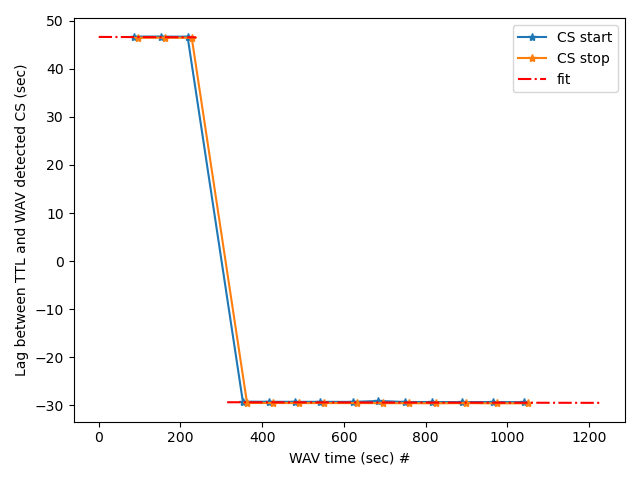

In [44]:
_, ax = plt.subplots(layout='tight')
csn_times_wav = np.stack((csn_wav_starts, csn_wav_stops), axis=1)
csn_lags_comb = np.stack((csn_start_lags, csn_stop_lags), axis=1)
hl = ax.plot(csn_times_wav, csn_lags_comb, '-*')
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = csn_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(csn_lags_comb.reshape(-1)), csn_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
for nrec in [0, 1]:
    
    wav_times = wav_sync_df.loc[wav_sync_df.nrec == nrec, ["wav_start", "wav_stop"]].values.squeeze()
    hfit = ax.plot(wav_times, wav_sync_df[wav_sync_df.nrec == nrec].p0.values + 
                   wav_sync_df[wav_sync_df.nrec == nrec].p1.values*wav_times, 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [45]:
def get_rec_num(rec_sync_df, times):
    """Identify in which recording each time in times occurs"""
    bins = np.sort(rec_sync_df.loc[:, ["wav_start", "wav_stop"]].values.flatten("C"))
    bin_loc = np.digitize(times, bins)
    indx_bool = bin_loc % 2 == 1
    indx_bool = bin_loc % 2 == 1
    indx_good = np.where(indx_bool)
    indx_bad = np.where(~indx_bool)
    
    nrec_ids = np.ones_like(indx_bool, dtype='int')
    bin_ind = (bin_loc / 2).astype(int)
    if np.any(indx_good):
        nrec_ids[indx_good] = rec_sync_df.loc[bin_ind[indx_good], "nrec"].values
    
    if np.any(indx_bad):
        nrec_ids[indx_bad] = -1

    return nrec_ids

In [46]:
from copy import deepcopy

def wav_epochs_to_eeg(wav_epochs_df, wav_sync_df):
    """wav_epochs_df must have start and stop field for each index"""
    wav_epochs_df2 = deepcopy(wav_epochs_df)
    nrec_start = get_rec_num(wav_sync_df, wav_epochs_df2.start)
    nrec_stop = get_rec_num(wav_sync_df, wav_epochs_df2.stop)
    nrec_bool = nrec_start == nrec_stop
    nrec_good = np.ones_like(nrec_start) * -1
    nrec_good[nrec_bool] = nrec_start
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], column="nrec", value=nrec_good)

    # Initialize default values for t_starts and t_stops
    t_starts = [None] * len(wav_epochs_df2)
    t_stops = [None] * len(wav_epochs_df2)
    
    for idx, it in enumerate(wav_epochs_df2.itertuples()):
        p_use = wav_sync_df.loc[wav_sync_df.nrec == it.nrec, ["p0", "p1"]].values.squeeze()
        if p_use.size > 0:
            t_start = it.start + p_use[0] + p_use[1] * it.start
            t_stop = it.stop + p_use[0] + p_use[1] * it.stop
            t_starts[idx] = t_start
            t_stops[idx] = t_stop
    
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_start_eeg", t_starts)
    wav_epochs_df2.insert(wav_epochs_df2.shape[1], "t_stop_eeg", t_stops)
    
    return wav_epochs_df2

In [47]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
csn_wav_epochs_aligned = wav_epochs_to_eeg(csn_wav_epochs.to_dataframe(), wav_sync_df)
csn_wav_epochs_aligned = Epoch({"start": csn_wav_epochs_aligned.t_start_eeg.values, 
                               "stop": csn_wav_epochs_aligned.t_stop_eeg.values, 
                               "label": ["CS+ from WAV file"]*csn_wav_epochs_aligned.shape[0]})


csn_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
csn_wav_epochs_aligned.save(csn_epochs_files)
sess.recinfo.write_epochs(csn_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.cs_wav_epochs.npy saved


## Now correct that drift and find corrected lags!

In [48]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
calls_accept_df = wav_epochs_to_eeg(calls_accept_df, wav_sync_df)
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)
good_calls.to_dataframe().sample(5)

/data2/Trace_FC/Recording_Rats/Rose/2022_06_20_habituation1/Rose_habituation1_denoised.usv_epochs.npy saved


,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label,nrec,t_start_eeg,t_stop_eeg,duration
20,183.399537,183.441760,183.399537,51.151018,0.042223,7.504525,1,1,,0,229.963923,230.006132,0.042223
2,11.473934,11.543731,11.473934,44.493778,0.069798,10.288462,1,1,,0,58.095888,58.165662,0.069798
24,310.636794,310.676863,310.636794,56.960973,0.040069,13.677602,1,1,,-1,NaN,NaN,0.040069
25,406.888841,406.912969,406.888841,46.430430,0.024128,4.357466,1,1,,1,377.519913,377.544037,0.024128
8,59.612667,59.672124,59.612667,40.378394,0.059457,26.386878,1,1,,0,106.218502,106.277939,0.059457


## Save notebook to working directory

In [49]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)